
___
# Recommender Systems with Python

Welcome to the code notebook for Recommender Systems with Python. In this lecture we will develop basic recommendation systems using Python and pandas.

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

There is no project for this topic, instead you have the option to work through the advanced lecture version of this notebook (totally optional!).

Let's get started!

## Import Libraries

In [61]:
import numpy as np
import pandas as pd
#pd.set_option('display.max_columns', 999)
import warnings
warnings.filterwarnings("ignore")

## Get the Data

In [62]:
column_names = ["user_id", "item_id", "rating", "timestamp"]
df = pd.read_csv("u.data", sep="\t", names = column_names)

In [63]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


**Now let's get the movie titles:**

In [64]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


**We can merge them together:**

In [65]:
df = pd.merge(left = df, right = movie_titles, on = "item_id")
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

**Let's create a ratings dataframe with average rating and number of ratings:**

In [67]:
df.groupby("title")["rating"].mean().sort_values(ascending=False).head()

title
They Made Me a Criminal (1939)                5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Name: rating, dtype: float64

In [68]:
df.groupby("title")["rating"].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [69]:
ratings = pd.DataFrame(df.groupby("title")["rating"].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


**Now set the number of ratings column:**

In [70]:
ratings["num_of_ratings"] = pd.DataFrame(df.groupby("title")["rating"].count())
ratings.head()

,rating,num_of_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


**Now a few histograms:**

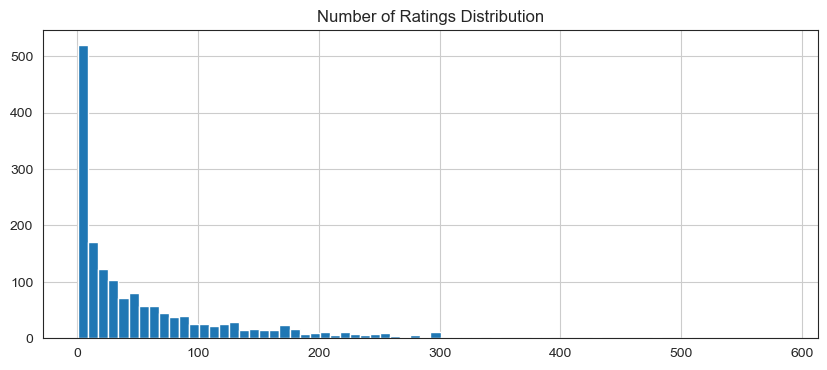

In [71]:
plt.figure(figsize=(10, 4))
ratings["num_of_ratings"].hist(bins = 70)
plt.title("Number of Ratings Distribution");

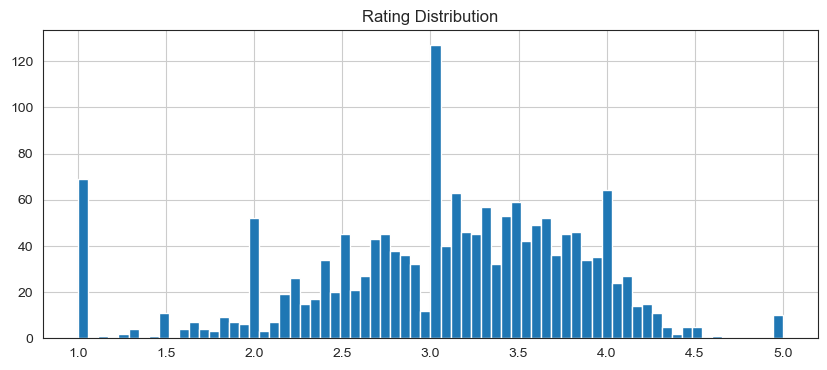

In [72]:
plt.figure(figsize=(10, 4))
ratings["rating"].hist(bins = 70)
plt.title("Rating Distribution");

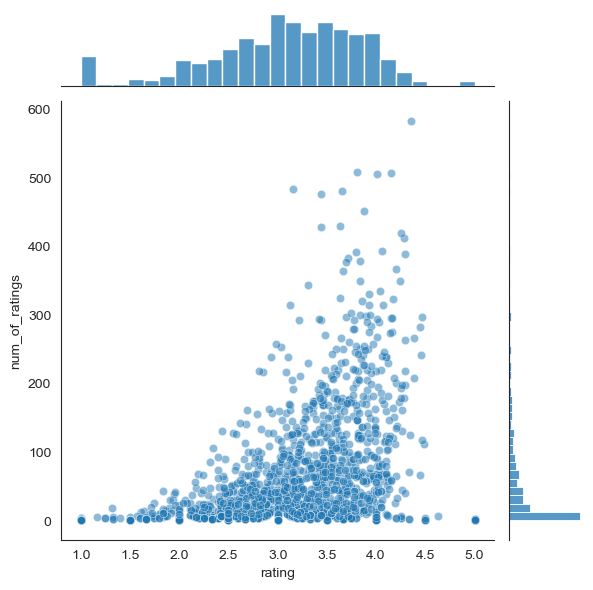

In [73]:
sns.jointplot(x = "rating", y = "num_of_ratings", data = ratings, alpha = 0.5);

**Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:**

## Recommending Similar Movies

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [74]:
moviemat = df.pivot_table(index = "user_id", columns="title", values = "rating")
moviemat.head().T

user_id,0,1,2,3,4
title,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,2.0,NaN,NaN,NaN
12 Angry Men (1957),NaN,5.0,NaN,NaN,NaN
187 (1997),NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...
Young Guns II (1990),NaN,NaN,NaN,NaN,NaN
"Young Poisoner's Handbook, The (1995)",NaN,NaN,NaN,NaN,NaN
Zeus and Roxanne (1997),NaN,NaN,NaN,NaN,NaN


**Most rated movie:**

In [75]:
ratings.sort_values(by = "num_of_ratings", ascending=False).head(10)

,rating,num_of_ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


**Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.**

In [76]:
ratings.head()

,rating,num_of_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


**Now let's grab the user ratings for those two movies:**

In [77]:
starwars_user_ratings = moviemat["Star Wars (1977)"]
liarliar_user_ratings = moviemat["Liar Liar (1997)"]
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

**We can then use ``corrwith()`` method to get correlations between two pandas series:**

In [78]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_starwars

title
'Til There Was You (1997)                0.872872
1-900 (1994)                            -0.645497
101 Dalmatians (1996)                    0.211132
12 Angry Men (1957)                      0.184289
187 (1997)                               0.027398
                                           ...   
Young Guns II (1990)                     0.228615
Young Poisoner's Handbook, The (1995)   -0.007374
Zeus and Roxanne (1997)                  0.818182
unknown                                  0.723123
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

In [79]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)
similar_to_liarliar

title
'Til There Was You (1997)                0.118913
1-900 (1994)                                  NaN
101 Dalmatians (1996)                    0.469765
12 Angry Men (1957)                      0.066272
187 (1997)                               0.175145
                                           ...   
Young Guns II (1990)                     0.352174
Young Poisoner's Handbook, The (1995)    0.445016
Zeus and Roxanne (1997)                 -0.500000
unknown                                  0.870388
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

**Let's clean this by removing `NaN` values and using a DataFrame instead of a series:**

In [80]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=["Correlation"])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


**Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie).**

In [81]:
corr_starwars.sort_values(by = "Correlation", ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
Safe Passage (1994),1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0
"Outlaw, The (1943)",1.0
"Line King: Al Hirschfeld, The (1996)",1.0


**Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).**

In [82]:
corr_starwars = corr_starwars.join(ratings["num_of_ratings"])
corr_starwars.head()

,Correlation,num_of_ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


**Now sort the values and notice how the titles make a lot more sense:**

In [88]:
corr_starwars[corr_starwars["num_of_ratings"] > 100].sort_values(by = "Correlation", ascending=False).head()

,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


**Now the same for the comedy Liar Liar:**

In [91]:
corr_liarliar = pd.DataFrame(similar_to_liarliar, columns = ["Correlation"])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings["num_of_ratings"])
corr_liarliar[corr_liarliar["num_of_ratings"] > 100].sort_values(by = "Correlation", ascending=False).head()

,Correlation,num_of_ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
